In [2]:
!pip install cnn_finetune

Processing /home/jovyan/.cache/pip/wheels/f4/ab/20/954e052b50cf464bb0cc1e4917f2a24f0fbc5ac51f60410bb7/cnn_finetune-0.6.0-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873/pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)


In [3]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from cnn_finetune import make_model
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.optim as optim
from glob import glob
from tqdm import tqdm
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

In [4]:
torch.cuda.is_available()

True

In [5]:
def show_image(image):
    plt.imshow(image)
    # pause a bit so that plots are updated
    plt.pause(0.01)

In [6]:
def convert_url_to_local_path(url):
    '''
    gets the location of the image in the shared directory so we don't have to redownload
    '''
    return '/home/jovyan/course/ladi/'+'/'.join(url.split('/')[3:])

def labeltonumpy_i(label):
    int_list = [int(x) for x in (label[1:-1].split(' '))]
    return np.array(int_list)

class MLCNN_Dataset(Dataset):

    def __init__(self, csv_file, label_csv, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with metadata.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.final_metadata = pd.read_csv(csv_file)
        
        # get the path in the shared directory
        self.final_metadata['local_path'] = self.final_metadata['url'].apply(convert_url_to_local_path)
        
        self.final_label = pd.read_csv(label_csv)
        
        self.final_label['label'] = self.final_label['label'].apply(labeltonumpy_i)
        
        self.final_data = pd.merge(self.final_metadata, 
                                        self.final_label,
                                       on="s3_path").drop(['Unnamed: 0_x','Unnamed: 0_y'],axis = 1)
        self.transform = transform
        
    def __len__(self):
        return len(self.final_metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## Load images from shared directory. There is no need to download images to local machine. ##
        local_path = self.final_metadata.iloc[idx]['local_path']
        url = self.final_metadata.iloc[idx]['url']
        try:
            image = Image.fromarray(io.imread(local_path))
            img_name = local_path
        except:
            image = Image.fromarray(io.imread(url))
            img_name = url
        uuid = self.final_data.iloc[idx, 1]
        timestamp = self.final_data.iloc[idx, 2]
        gps_lat = self.final_data.iloc[idx, 3]
        gps_lon = self.final_data.iloc[idx, 4]
        gps_alt = self.final_data.iloc[idx, 5]
        file_size = self.final_data.iloc[idx, 6]
        width = self.final_data.iloc[idx, 7]
        height = self.final_data.iloc[idx, 8]
        label = self.final_data.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label}#, 'uuid': uuid, 'timestamp': timestamp, 'gps_lat': gps_lat, 'gps_lon': gps_lon, 'gps_alt': gps_alt, 'orig_file_size': file_size, 'orig_width': width, 'orig_height': height}

        return sample

final_dataset = MLCNN_Dataset(csv_file = 'final_metadata.csv', label_csv = 'changedLabels.csv')

scale = transforms.Resize(768)
crop = transforms.RandomCrop(512)
rotate = transforms.RandomRotation(25)
#flip_demo = transforms.RandomHorizontalFlip(1) # flip with 100% chance just to demo
flip = transforms.RandomHorizontalFlip(p=0.5)
composed = transforms.Compose([scale,
                               crop,
                               rotate,
                               flip,
                                transforms.ToTensor()])

Transformed_dataset = MLCNN_Dataset(csv_file = 'final_metadata.csv', label_csv = 'changedLabels.csv',
                                          transform = transforms.Compose([scale, crop, rotate, flip, transforms.ToTensor()]))

In [7]:
Transformed_dataset.final_data.head()

,uuid,timestamp,gps_lat,gps_lon,gps_alt,file_size,width,height,s3_path,url,local_path,label
0,f3a9a1d1324b747b16d5ddd88b1e582d4430d952,2015-10-08 12:33:11,33.642213,-79.835887,292.0,6388659.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1013/20195/DSC_0512_...,https://ladi.s3-us-west-2.amazonaws.com/Images...,/home/jovyan/course/ladi/Images/FEMA_CAP/1013/...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,489efbec368d78a08e08aef15f21409745231328,2015-10-08 12:33:32,33.647137,-79.829637,306.0,6283783.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1013/20195/DSC_0516_...,https://ladi.s3-us-west-2.amazonaws.com/Images...,/home/jovyan/course/ladi/Images/FEMA_CAP/1013/...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,38b2cdf28c9f06cf3adac2f1dd0c50332e3a3ab9,2015-10-08 12:33:43,33.650238,-79.834105,301.0,6990298.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1013/20195/DSC_0521_...,https://ladi.s3-us-west-2.amazonaws.com/Images...,/home/jovyan/course/ladi/Images/FEMA_CAP/1013/...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,405c090c177e5f22cabc7ff4124dbbdd66bd3413,2015-10-08 12:35:10,33.611918,-79.836295,331.0,6525512.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1013/20195/DSC_0529_...,https://ladi.s3-us-west-2.amazonaws.com/Images...,/home/jovyan/course/ladi/Images/FEMA_CAP/1013/...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,d3f72158df1bea3fbe99c1b9c0df2c1bc1ab1a94,2015-10-09 11:01:41,33.476848,-79.556262,388.0,6244449.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1013/20211/DSC_1028_...,https://ladi.s3-us-west-2.amazonaws.com/Images...,/home/jovyan/course/ladi/Images/FEMA_CAP/1013/...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [8]:
batch_size = 16
test_split_ratio = .3
shuffle_dataset = True
random_seed= 76

# Creating data indices for training and validation splits:
dataset_size = len(Transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split_ratio * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(Transformed_dataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(Transformed_dataset, batch_size=batch_size,
                                                sampler=test_sampler, num_workers = 0)

In [9]:

#Medium Code
# files = glob('img_align_celeba/*.jpg')
# shuffle = np.random.permutation(len(files))
# for i in ['train', 'valid']:
#     os.mkdir(os.path.join('/tmp/', i))
    
# valid_dict = {}
# valid_file_names = []
# for i in tqdm(shuffle[:60780]):
#     file_name = files[i].split('/')[-1]
#     labels = np.array(label_df[label_df.index==file_name])
#     valid_dict[file_name] = labels
#     valid_file_names.append(file_name)
#     os.rename(files[i], os.path.join('/tmp/', '/tmp/valid', file_name))
# valid_df.index = valid_file_names
# valid_df.columns = ['labels']

## uncomment the below given line to check the head of the dataframe
# valid_df.head()

In [10]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 128, 63, 63
            nn.MaxPool2d(2), #op: 256, 30, 30
            nn.ReLU() #op: 256, 30, 30
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3), # 256, 30, 30
            nn.MaxPool2d(2), #op: 512, 14, 14
            nn.ReLU(), #op: 512, 14, 14
            nn.Dropout(0.2)
        )
        self.Linear1 = nn.Linear(460800, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, 15)
        
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0),-1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        return F.sigmoid(x)

In [11]:
model = MultiClassifier().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [12]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

In [13]:
#our code
torch.autograd.set_detect_anomaly = False
def fit_model(epochs, model, dataloader, phase = 'training', volatile = False):
    
    pprint("Epoch: {}".format(epochs))
    
    if phase == 'training':
        model.train()
        
    if phase == 'validataion':
        model.eval()
        volatile = True
        
    running_loss = []
    running_acc = []
    b = 0
    #print('a')
    for i, data in enumerate(dataloader):
        #print('b')

        inputs, target = data['image'].cuda(), data['label'].float().cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
            #print('c')
        ops = model(inputs)
        
        acc_ = []
        for j, d in enumerate(ops, 0):
            #print('d')
            acc = pred_acc(torch.Tensor.cpu(target[j]), torch.Tensor.cpu(d))
            acc_.append(acc)

        loss = criterion(ops, target)
                
        running_loss.append(loss.item())
        running_acc.append(np.asarray(acc_).mean())
        b += 1
        #print('e')
        if phase == 'training':
            
            loss.backward()
        
            optimizer.step()
            #print('f')
        print(f'[epoch {epochs}, batch {i +1} ] average loss: {loss.item()}')
            
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    #print('g')

    pprint("{} loss is {} ".format(phase,total_batch_loss))
    pprint("{} accuracy is {} ".format(phase, total_batch_acc))
    print("Saving epoch: {}".format(epochs))
    PATH = 'ProjectModels/epoch_{}.pth'.format(epochs)
    torch.save(model, PATH)
    return total_batch_loss, total_batch_acc

In [14]:
!nvidia-smi
#Make sure GPU doesn't forget to be a GPU

Wed Jul 29 23:05:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P0    35W /  70W |   2481MiB / 15079MiB |     79%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [15]:
newModel = torch.load('ProjectModels/epoch_1.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'ProjectModels/epoch_1.pth'

In [ ]:
#This better work

# --> Ctrl + Enter at your own risk <--

trn_losses = []; trn_acc = []
val_losses = []; val_acc = []
for i in tqdm(range(1, 20)):
    trn_l, trn_a = fit_model(i, model, train_loader)
    val_l, val_a = fit_model(i, model, test_loader, phase = 'validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)

  0%|          | 0/19 [00:00<?, ?it/s]

'Epoch: 1'
[epoch 1, batch 1 ] average loss: 0.693316638469696
[epoch 1, batch 2 ] average loss: 0.3732881546020508
[epoch 1, batch 3 ] average loss: 0.2624911963939667
[epoch 1, batch 4 ] average loss: 0.25646084547042847
[epoch 1, batch 5 ] average loss: 0.2606492042541504
[epoch 1, batch 6 ] average loss: 0.2714749276638031
[epoch 1, batch 7 ] average loss: 0.27869948744773865
[epoch 1, batch 8 ] average loss: 0.30626970529556274
[epoch 1, batch 9 ] average loss: 0.2298632711172104
[epoch 1, batch 10 ] average loss: 0.21362896263599396
[epoch 1, batch 11 ] average loss: 0.23028840124607086
[epoch 1, batch 12 ] average loss: 0.22516320645809174
[epoch 1, batch 13 ] average loss: 0.27759239077568054
[epoch 1, batch 14 ] average loss: 0.2737877666950226
[epoch 1, batch 15 ] average loss: 0.24969704449176788
[epoch 1, batch 16 ] average loss: 0.19778500497341156
[epoch 1, batch 17 ] average loss: 0.2216392606496811
[epoch 1, batch 18 ] average loss: 0.24976490437984467
[epoch 1, batch 1

In [13]:
PATH = 'ProjectModels/epoch_1_unfinished2.pth'
torch.save(newModel, PATH)

NameError: name 'newModel' is not defined

In [ ]:
'''lmodel = MultiClassifier()
loadedModel = lmodel.load_state_dict(torch.load(PATH))
print(fit_model(i, loadedModel, test_loader, phase = 'validation'))'''

In [24]:
!tar -xzf course/final_exercise_evaluation/1596039411.tar.gz -C FinalProject/TestDataset/dataset.csv

tar (child): course/final_exercise_evaluation/1596039411.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [15]:
import pickle
with open("secondHalf.txt", "wb") as fp:   #Pickling
    pickle.dump(allPredsSecond, fp)

OSError: [Errno 28] No space left on device

In [13]:
model = torch.load('./ProjectModels/epoch_1_unfinished2.pth')
model.eval()

MultiClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (Linear1): Linear(in_features=460800, out_features=1024, bias=True)
  (Linear2): Linear(in_features=1024, out_features=256, bias=True)
  (Linear3): Linear(in_features=256, ou

  0%|          | 0/900 [00:00<?, ?it/s]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<RoundBackward>)


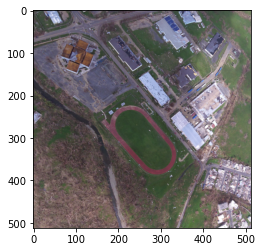

In [37]:
allPreds = []
for i in tqdm(range(100,1000)):
    #bigTestLoader = torch.utils.data.DataLoader(allPreds[i:i+8], batch_size=8, num_workers = 0)
    #batchPreds = []
    pathBefore = 'TestDataset/'
    pathString = 'img' + (3-len(str(i)))*'0' + str(i) + '.png'
    composedImage = composed(Image.fromarray(io.imread(pathBefore+pathString)))
    bigTestLoader = torch.utils.data.DataLoader([composedImage], batch_size=1, num_workers = 0)
    #print(pathString)
    for idx, d in enumerate(bigTestLoader):
        print(torch.round(model(d.cuda())))
    plt.imshow(Image.fromarray(io.imread(pathBefore+pathString)))
    break

In [ ]:
newPreds = []

In [ ]:
for i in tqdm(range(0,1000,8)):
    bigTestLoader = torch.utils.data.DataLoader(allPreds[i:i+8], batch_size=8, num_workers = 0)
    for idx, d in enumerate(bigTestLoader):
        predictArr = model(d.cuda())
        newPreds.append(torch.round(predictArr))

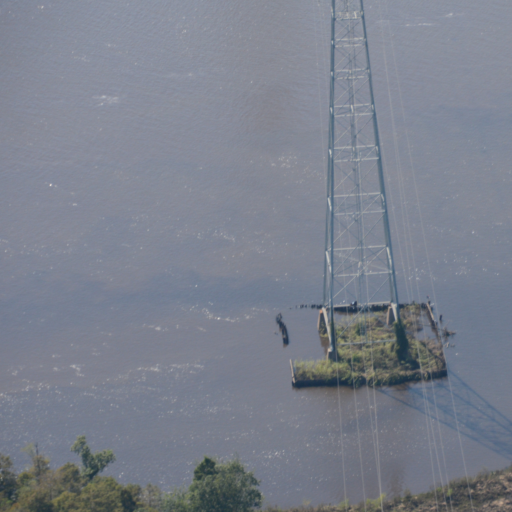

In [22]:
imgArr2[0]

In [ ]:
'''['damage:flood/water',
 'damage:rubble',
 'damage:misc',
 'damage:smoke/fire',
 'infrastructure:building',
 'infrastructure:pipe',
 'damage:washout',
 'damage:landslide',
 'infrastructure:railway',
 'infrastructure:road',
 'infrastructure:dam-levee',
 'infrastructure:bridge',
 'infrastructure:utility-line',
 'infrastructure:communications-tower',
 'infrastructure:water-tower']'''